In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy

In [31]:
torch.manual_seed(1)

In [32]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [33]:
# Data loader func
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [34]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        # self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten as one dimension
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x

In [35]:
#train function
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt={}
    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0

        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss

            # Backward and optimize
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            #print(epoch,i)
            
            #Weight Collection
            if epoch % 3 == 0:
                for name, parameter in model.named_parameters():
                    #print(name)
                    if'weight' in name:
                        modelParamWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
                        #print(modelParamWgt)

            #Print Status
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\n',flush = True)
               
                        
    trainAvgLoss = lossSum/train_batch_size
    print("Train Avg loss:",trainAvgLoss)
                        
    return train_epoch,train_losses,train_acc,trainAvgLoss, modelParamWgt

In [36]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss} ')
    return netTest_acc1, netTest_loss

In [37]:
# M = Model()
# loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(M.parameters(), lr=0.0015, weight_decay = 1e-2)

# max_epochs = 15
# train_batch_size = int(600)
# test_batch_size = int(100)
# status_interval = 100

# a=[]
# for k in M.parameters():
#     a.append(torch.numel(k))
# print(f'Total no of parameters in Model :{np.sum(a)} for with batch size:{train_batch_size}')


In [38]:
#train_epoch,train_losses,train_acc,trainAvgLoss, modelParamWgt = trainFunc(M,max_epochs,train_batch_size,status_interval)

In [39]:
#testAcc, testLoss = testFunction(M,loss_func,test_batch_size)


In [40]:
# paramDF = pd.DataFrame.from_dict(data=modelParamWgt,orient='index')
# print(paramDF)

In [41]:
# #PCA Dim Reduction.
# pcaOperation =  PCA(n_components=2)

# pcaVal = pcaOperation.fit_transform(paramDF)

# pcaDf = pd.DataFrame(data = pcaVal, columns = ['x','y'])

# print(pcaVal,'\n',pcaDf)

In [42]:
# #Visualize the Optimization Process

# plt.scatter(pcaDf['x'],pcaDf['y'],color="Blue")
# # plt.set_xlabel("Batch",color="Green")
# # plt.set_ylabel("CrossEntropy Loss",color = "blue")
# plt.title("PCA for model",color="g")

Iteration No: 0
strated
Train O/P: Epoch [1/6], Step [100/100], Loss: 0.2739
Train O/P: Epoch [2/6], Step [100/100], Loss: 0.1822
Train O/P: Epoch [3/6], Step [100/100], Loss: 0.1529
Train O/P: Epoch [4/6], Step [100/100], Loss: 0.1282
Train O/P: Epoch [5/6], Step [100/100], Loss: 0.1173
Train O/P: Epoch [6/6], Step [100/100], Loss: 0.1222
Train Avg loss: tensor(0.0172, grad_fn=<DivBackward0>)
Accuracy of the network on the test images: 97.56% & Test Loss: 0.08795576523290947 


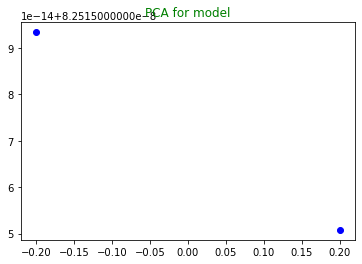

Iteration No: 1
strated
Train O/P: Epoch [1/6], Step [100/100], Loss: 0.3403
Train O/P: Epoch [2/6], Step [100/100], Loss: 0.1531
Train O/P: Epoch [3/6], Step [100/100], Loss: 0.1777
Train O/P: Epoch [4/6], Step [100/100], Loss: 0.1268
Train O/P: Epoch [5/6], Step [100/100], Loss: 0.1177
Train O/P: Epoch [6/6], Step [100/100], Loss: 0.0929
Train Avg loss: tensor(0.0185, grad_fn=<DivBackward0>)
Accuracy of the network on the test images: 97.47% & Test Loss: 0.09372221751604229 


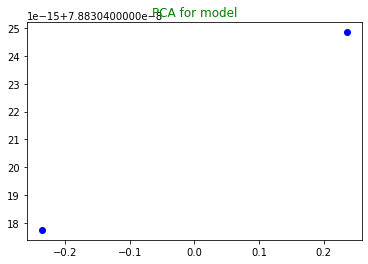

Iteration No: 2
strated
Train O/P: Epoch [1/6], Step [100/100], Loss: 0.2980
Train O/P: Epoch [2/6], Step [100/100], Loss: 0.2384
Train O/P: Epoch [3/6], Step [100/100], Loss: 0.1505
Train O/P: Epoch [4/6], Step [100/100], Loss: 0.1369
Train O/P: Epoch [5/6], Step [100/100], Loss: 0.1119
Train O/P: Epoch [6/6], Step [100/100], Loss: 0.1010
Train Avg loss: tensor(0.0187, grad_fn=<DivBackward0>)
Accuracy of the network on the test images: 97.46% & Test Loss: 0.09331844775704667 


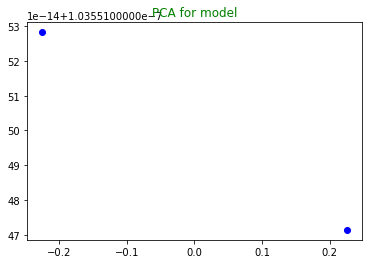

Iteration No: 3
strated
Train O/P: Epoch [1/6], Step [100/100], Loss: 0.2786
Train O/P: Epoch [2/6], Step [100/100], Loss: 0.1950
Train O/P: Epoch [3/6], Step [100/100], Loss: 0.1837
Train O/P: Epoch [4/6], Step [100/100], Loss: 0.1461
Train O/P: Epoch [5/6], Step [100/100], Loss: 0.0934
Train O/P: Epoch [6/6], Step [100/100], Loss: 0.1285
Train Avg loss: tensor(0.0185, grad_fn=<DivBackward0>)
Accuracy of the network on the test images: 97.28% & Test Loss: 0.10049604055937379 


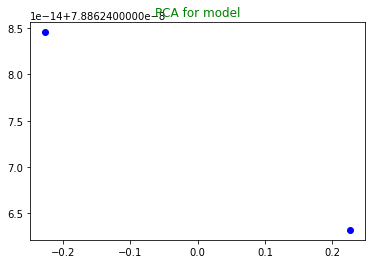

Iteration No: 4
strated
Train O/P: Epoch [1/6], Step [100/100], Loss: 0.3203
Train O/P: Epoch [2/6], Step [100/100], Loss: 0.1820
Train O/P: Epoch [3/6], Step [100/100], Loss: 0.1713
Train O/P: Epoch [4/6], Step [100/100], Loss: 0.1315
Train O/P: Epoch [5/6], Step [100/100], Loss: 0.1285
Train O/P: Epoch [6/6], Step [100/100], Loss: 0.0903
Train Avg loss: tensor(0.0194, grad_fn=<DivBackward0>)
Accuracy of the network on the test images: 97.11% & Test Loss: 0.10446112410631031 


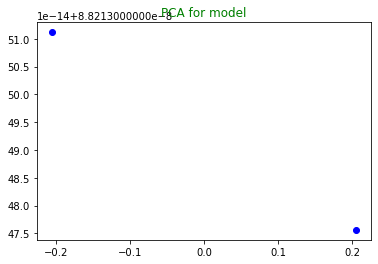

Iteration No: 5
strated
Train O/P: Epoch [1/6], Step [100/100], Loss: 0.3312
Train O/P: Epoch [2/6], Step [100/100], Loss: 0.1696
Train O/P: Epoch [3/6], Step [100/100], Loss: 0.1220
Train O/P: Epoch [4/6], Step [100/100], Loss: 0.1842
Train O/P: Epoch [5/6], Step [100/100], Loss: 0.1321
Train O/P: Epoch [6/6], Step [100/100], Loss: 0.0963
Train Avg loss: tensor(0.0175, grad_fn=<DivBackward0>)
Accuracy of the network on the test images: 97.66% & Test Loss: 0.08859183931257576 


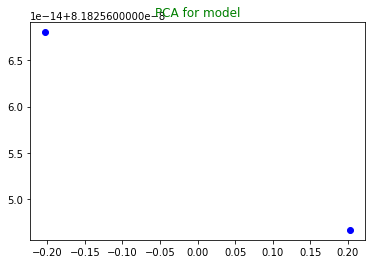

Iteration No: 6
strated
Train O/P: Epoch [1/6], Step [100/100], Loss: 0.3216
Train O/P: Epoch [2/6], Step [100/100], Loss: 0.1810
Train O/P: Epoch [3/6], Step [100/100], Loss: 0.1470
Train O/P: Epoch [4/6], Step [100/100], Loss: 0.1423
Train O/P: Epoch [5/6], Step [100/100], Loss: 0.1415
Train O/P: Epoch [6/6], Step [100/100], Loss: 0.1013
Train Avg loss: tensor(0.0191, grad_fn=<DivBackward0>)
Accuracy of the network on the test images: 97.35% & Test Loss: 0.09697424966609106 


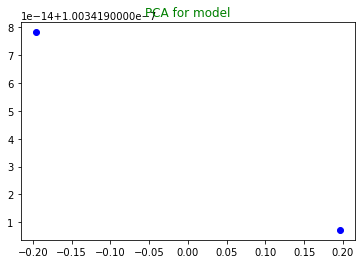

Iteration No: 7
strated
Train O/P: Epoch [1/6], Step [100/100], Loss: 0.2836
Train O/P: Epoch [2/6], Step [100/100], Loss: 0.1656
Train O/P: Epoch [3/6], Step [100/100], Loss: 0.1695
Train O/P: Epoch [4/6], Step [100/100], Loss: 0.0915
Train O/P: Epoch [5/6], Step [100/100], Loss: 0.1365
Train O/P: Epoch [6/6], Step [100/100], Loss: 0.0892
Train Avg loss: tensor(0.0184, grad_fn=<DivBackward0>)
Accuracy of the network on the test images: 97.54% & Test Loss: 0.0910612963954918 


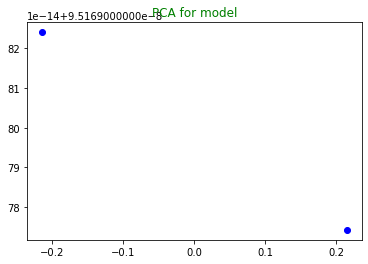

In [47]:
#Main Implementation

for itr in range(2):
    print('Iteration No:', itr)
    itr = Model()
    j = copy.deepcopy(itr) 
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(itr.parameters(), lr=0.0015, weight_decay = 1e-4)

    max_epochs = 6
    train_batch_size = int(64)
    test_batch_size = int(100)
    status_interval = 50

    train_epoch,train_losses,train_acc,trainAvgLoss, modelParamWgt = trainFunc(itr,max_epochs,train_batch_size,status_interval)

    testAcc, testLoss = testFunction(itr,loss_func,test_batch_size)

    paramDF = pd.DataFrame.from_dict(data=modelParamWgt,orient='index')
    
    #PCA Dim Reduction.
    pcaOperation =  PCA(n_components=2)

    pcaVal = pcaOperation.fit_transform(paramDF)

    pcaDf = pd.DataFrame(data = pcaVal, columns = ['x','y'])

    #Visualize the Optimization Process

    plt.scatter(pcaDf['x'],pcaDf['y'],color="Blue")
    plt.title("PCA for model",color="g")
    

    # pcaDict [itr] = pcaVal

    # # print("PCA DF",itr,":",j)
plt.show()
   
    
# pcaDF = pd.DataFrame(data = pcaDict, columns = ['iterations','x','y'])

    



In [48]:
 #Visualize the Optimization Process
pcaDf

,x,y
0,0.214258,9.516977e-08
1,-0.214258,9.516982e-08
